In [1]:
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

from imutils import paths
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imutils
import random
import pickle

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([(

In [2]:
INPUT_SHAPE=[224, 224, 3]
EPOCHS = 10
LEARNING_RATE = 0.01 # default value for Adam Optimizer
BATCH_SIZE = 32
DATASET_DIR = 'dataset'
DATASET_NAME = 'multi-label-dataset'
CURR_DIR = os.getcwd()
#TRAIN_CSV = 'train.csv'
#LABEL_DICT = {'dmg': 'damage', 'whl': 'whole', 'mnr': 'minor', 'mod': 'moderate', 'svr': 'severe', 'frt': 'front', 'rr': 'rear', 'sd': 'side'}
SUB_FOLDERS = ['damage', 'whole']

print(CURR_DIR)

/Users/ravisher/Development/FatehLabs/AIDD-Project/Damage-Whole-Classifier


In [3]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)


W1130 10:26:18.058159 4675106240 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



In [4]:
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(2,activation='softmax')(x) #final layer with softmax activation

In [5]:
model=Model(inputs=base_model.input,outputs=preds)

In [6]:
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [7]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies
# this is where you specify the path to the main data folder
train_generator=train_datagen.flow_from_directory('/Users/ravisher/Development/FatehLabs/AIDD-Project/Damage-Whole-Classifier/dataset/',
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 1840 images belonging to 2 classes.


In [8]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [9]:
step_size_train=train_generator.n//train_generator.batch_size
H = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   epochs=5)

W1130 10:26:30.639563 4675106240 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Epoch 1/5
57/57 [==============================] - 624s 11s/step - loss: 1.1929 - accuracy: 0.8158
Epoch 2/5
57/57 [==============================] - 592s 10s/step - loss: 0.2170 - accuracy: 0.9204
Epoch 3/5
57/57 [==============================] - 608s 11s/step - loss: 0.1365 - accuracy: 0.9463
Epoch 4/5
57/57 [==============================] - 556s 10s/step - loss: 0.1609 - accuracy: 0.9292
Epoch 5/5
57/57 [==============================] - 599s 11s/step - loss: 0.0795 - accuracy: 0.9668


In [32]:
model.save_weights('car-damage-whole-TL-weights.h5')
model.save('car-damage-whole-TL-model.h5')

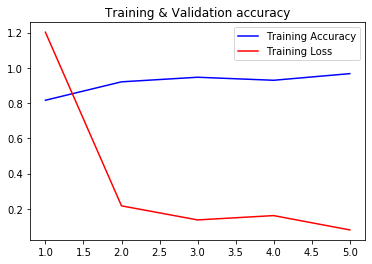

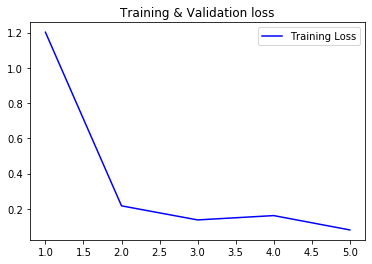

In [11]:
acc = H.history['accuracy']
loss = H.history['loss']

# val_acc = H.history['val_accuracy']
# val_loss = H.history['val_loss']

epochs = range(1, len(acc) + 1)

# Training and Validation accuracy
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.title('Training & Validation accuracy')
plt.legend()

plt.figure()

# Training and Validation Loss
plt.plot(epochs, loss, 'b', label='Training Loss')
# plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training & Validation loss')
plt.legend()

plt.show()

Probs: [0.7574817  0.24251829]
Probs: [0.6342516  0.36574838]
Probs: [0.516711 0.483289]
Probs: [0.63741165 0.36258835]
Probs: [0.8246707  0.17532927]


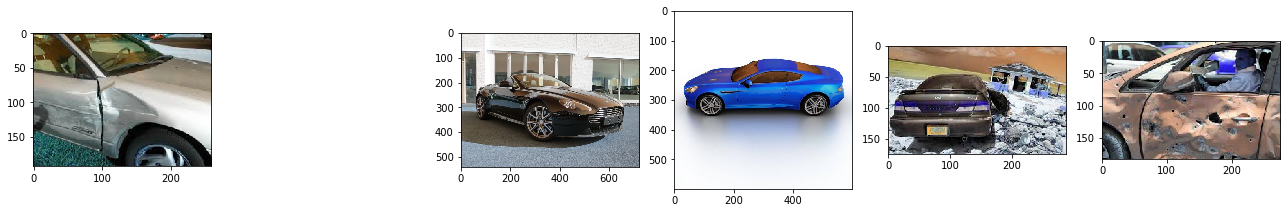

In [41]:
test_dir=os.path.join('/Users/ravisher/Desktop', 'test-one-car')
test_images = [os.path.join(test_dir, i) for i in os.listdir(test_dir)]
plt.figure(figsize=(30, 20))
columns = 8
for (i, img) in enumerate(test_images):
    image = cv2.imread(img)
    if image is not None:
        output = imutils.resize(image, width=400)
        plt.subplot(8 / columns + 1, columns, i + 1)
        imgplot = plt.imshow(image)
        # pre-process the image for classification
        image = cv2.resize(image, (224, 224))
        image = img_to_array(image)
        image = image.astype("float") / 255.0
        image = np.expand_dims(image, axis=0)
        proba = model.predict(image)[0]
        print('Probs:', proba)
plt.show()